<div style="width:100%; text-align:center; margin: 40px 0;">
    <h1 style="color: #003366; font-size: 40px; font-weight:bold; text-shadow: 2px 2px 5px grey;">
        Énergie Électrique en France
    </h1>
    <hr style="width: 50%; height: 3px; background-color: #003366; border: none;">
    <p style="font-style:italic; font-size:18px; color: #555;">
        Une exploration approfondie de l'énergie électrique en France
    </p>
</div>


<h2 style="padding:16px; color:#FFF; background:#07D">Imports</h2>

In [61]:
# Data
URL = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/"
url_geo = 'https://france-geojson.gregoiredavid.fr/repo/regions.geojson'

# Imports
import requests
import sqlite3
import time
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, VBox, HBox, DatePicker, Output, Dropdown
from IPython.display import display, clear_output, Image
from matplotlib.animation import FuncAnimation, PillowWriter
from sqlalchemy import create_engine

<h2 style="padding:16px; color:#FFF; background:#07D">I. Présentation des données</h2>

éCO2mix est un outil créé par RTE France afin de mieux connaître en temps réel l'électricité en France. RTE France met à disposition gratuitement, via plusieurs API, les base de données utilisée par éCO2mix qui fournissent les données de 2013 à aujourd'hui. Les informations fournient par les API sont les suivantes :

- Consommation d’électricité en France métropolitaine (hors Corse) et prévisions calculées la veille et en début d’après-midi le jour J ;
- Production d’électricité française par filière en valeur et en pourcentage ;
- Échanges commerciaux d’électricité avec les 6 pays voisins ;
- Émissions de CO2 que génère la production d’électricité ;
- Données mensuelles à l’échelle régionale : consommation, production et flux interrégionaux.

Les données sont séparées en 4 bases de données :

- Données éCO2mix nationales temps réel
- Données éCO2mix nationales consolidées et définitives
- Données éCO2mix régionales temps réel
- Données éCO2mix régionales consolidées et définitives

<h2 style="padding:16px; color:#FFF; background:#07D">II. Objectif de l'étude</h2>

Cette étude a pour but l'analyse de la production, de la consommation et des échanges d'électricité en France depuis 2013. L'objectif est de déterminer les parts des différentes filières dans la production d'électricité et de voir leur évolution au cours du temps, de comprendre les tendances dans la consommation d'électricité sur plusieurs échelles de temps et d'identifier la tendance commerciale de la France avec ses pays voisins sur le marché de l'électricité. Enfin, cette étude nous permettra d'étudier l'impact de la production d'électricité sur les émissions de CO2 en France.

<h2 style="padding:16px; color:#FFF; background:#07D">III. Récupération des données</h2>

In [63]:
## Functions to get data from the API ##

def fetch_data_by_date(data:str, start:int, rows:int, date:str):
    """Fetch data from a dataset by date and offset
    
    Parameters
    ----------
    data : str
        Name of the dataset.
    start : int
        Offset.
    rows : int
        Number of rows.
    date : str
        Date of the data.

    Returns
    -------
    dict
        Dictionary containing the data. 
    """
    url = f"{URL}{data}" + "/records"
    params = {
        "offset" : start,
        "rows": rows,
        "where": f"date='{date}'"
    }
    response = requests.get(url, params=params)
    data=[{}]
    if response.status_code == 200:
        data = response.json()
        return data.get('results', {})
    else:
        print(f"Échec de la requête: {response.status_code}")
        print(response.text)
        return 
    
def get_length_per_date(data:str, date:str):
    """Get the number of rows for a given date

    Parameters
    ----------
    data : str
        Name of the dataset.
    date : str
        Date of the data.

    Returns
    -------
    int
        Number of rows.
    """
    url = f"{URL}{data}" + "/records"
    params = {
        "select": "date",
        "rows": 1,
        "where": f"date='{date}'"
    }
    response = requests.get(url, params=params)
    data=[{}]
    if response.status_code == 200:
        data = response.json()
        return data.get('total_count')
    else:
        print(f"Échec de la requête: {response.status_code}")
        print(response.text)
        return
    

def get_date(data: str, first: bool=True) -> str:
    """Get the minimum or maximum date in a dataset

    Parameters
    ----------
    data : str
        Name of the dataset.
    first : bool, optional
        If True, get the minimum date, else get the maximum date. The default is True.
    
    Returns
    -------
    str
        Date.
    """
    date = "date" if first else "-date"
    
    url = f"{URL}{data}" + "/records"
    params = {
        "select": "date",
        "rows": 1,
        "order_by": date,
    }
    response = requests.get(url, params=params)
    data=[{}]
    if response.status_code == 200:
        data = response.json()
        return data.get('results')[0]['date']
    else:
        print(f"Échec de la requête: {response.status_code}")
        print(response.text)
        return

In [4]:
## Create the database engine ##
engine = create_engine('sqlite:///database.db') 

In [5]:
def preprocess_data(data):
    """Preprocess the data before inserting it into the database

    Parameters
    ----------
    data : DataFrame
        Data to be preprocessed.

    Returns
    -------
    DataFrame
        Preprocessed data.
    """
    if 'column_68' in data.columns:
        del data['column_68']

    if 'eolien_terrestre' in data.columns:
        del data['eolien_terrestre']

    if 'eolien_offshore' in data.columns:
        del data['eolien_offshore']

    if 'stockage_batterie' in data.columns:
        del data['stockage_batterie']

    if 'destockage_batterie' in data.columns:
        del data['destockage_batterie']
    return data

def insert_data(from_data: str, table_name: str) -> None:
    """Get data from a dataset and insert it into a sqlite database

    Parameters
    ----------
    from_data : str
        Name of the dataset from the API.
    table_name : str
        Name of the table in the database.
    """
    step = 100 # Number of rows to be retrieved per request (API limit)
    start_date = get_date(from_data)
    end_date = get_date(from_data, first = False)
    current_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    while current_date <= end_date:
        formatted_date = str(current_date.strftime('%Y-%m-%d'))
        lines_per_date = get_length_per_date(from_data, str(formatted_date))
        print(formatted_date)
        
        for i in range(0, lines_per_date, step):
            rows = min(step, lines_per_date - i)
            try:
                data = fetch_data_by_date(from_data, i, rows, str(formatted_date))
                df = pd.DataFrame(data)
                df = preprocess_data(df)
                df.to_sql(table_name, engine, if_exists='append', index=False)
                    
            except Exception as e:
                print(f"Erreur lors de l'insertion des données pour la date {formatted_date}, offset {i}: {e}")
                print("Réessai dans 5 secondes...")
                time.sleep(5)  
                i -= step  
                continue
                
        current_date += timedelta(days=1)
        

In [ ]:
## RUN TO DOWNLOAD THE DATABASE ##

#print("Filling national table...")
#insert_data("eco2mix-national-cons-def", "national")
#insert_data("eco2mix-national-tr", "national")

#print("Filling regional table...")
#insert_data("eco2mix-regional-cons-def", "regional")
#insert_data("eco2mix-regional-tr", "regional")

In [64]:
### FUNCTIONS TO GET DATA FROM DATABASE ###

def get_all_data(table_name, db_file='database.db'):
    """
    Get all data from a table using sqlite3.

    Parameters:
        table_name (str): Name of the table in the database.
        db_file (str): Path to the SQLite database file.

    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """
    conn = sqlite3.connect(db_file)

    query = f"SELECT * FROM {table_name}"

    df = pd.read_sql(query, conn)

    conn.close()
    return df

def get_data_between_dates(table_name, start_date, end_date, db_file='database.db'):
    """
    Get data from a table between two dates using sqlite3.

    Parameters:
        table_name (str): Name of the table in the database.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        db_file (str): Path to the SQLite database file.

    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """
    conn = sqlite3.connect(db_file)

    query = f"""
        SELECT *
        FROM {table_name}
        WHERE date >= '{start_date}' AND date <= '{end_date}'
    """

    df = pd.read_sql(query, conn)

    conn.close()
    return df

def get_data_by_date(table_name, date, db_file='database.db'):
    """
    Get data from a table for a given date using sqlite3.

    Parameters:
        table_name (str): Name of the table in the database.
        date (str): Date in 'YYYY-MM-DD'
        db_file (str): Path to the SQLite database file.

    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """
    conn = sqlite3.connect(db_file)

    query = f"SELECT * FROM {table_name} WHERE date = '{date}'"

    df = pd.read_sql(query, conn)

    conn.close()
    return df


def get_trade_data(start_date, end_date,  db_file='database.db'):
    """
    Get trade data between two dates using sqlite3.

    Parameters:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        db_file (str): Path to the SQLite database file.
    
    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """

    conn = sqlite3.connect(db_file)

    query = f"""
    SELECT date_heure,
           ech_comm_angleterre, 
           ech_comm_espagne, 
           ech_comm_italie, 
           ech_comm_suisse, 
           ech_comm_allemagne_belgique 
    FROM national
    WHERE date_heure >= '{start_date}' AND date_heure <= '{end_date}'
    ORDER BY date_heure;
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()

    df['date_heure'] = pd.to_datetime(df['date_heure'])
    df.set_index('date_heure', inplace=True)
    return df

def get_aggregated_data_by_filiere(table_name, start_date, end_date, filiere, db_file='database.db'):
    """
    Get aggregated data by filiere between two dates using sqlite3.

    Parameters:
        table_name (str): Name of the table in the database.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        filiere (str): Name of the filiere.
        db_file (str): Path to the SQLite database file.

    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """

    conn = sqlite3.connect(db_file)

    query = f"""
        SELECT libelle_region, SUM({filiere}) as total_production
        FROM {table_name}
        WHERE date >= '{start_date}' AND date <= '{end_date}'
        GROUP BY libelle_region
    """

    df = pd.read_sql(query, conn)
    conn.close()
    return df

<h2 style="padding:16px; color:#FFF; background:#07D">IV. Analyse de la consommation</h2>

La consommation d'électricité est un enjeu majeur tant sur le plan économique que sur celui de l'environnement. Elle évolue au fil du temps en fonction des avancées technologiques et des politiques énergétiques. Ces dernières années, les préoccupations environnementales croissantes ont placé la consommation d'électricité au centre des débats. Nous allons donc essayer de comprendre comment varie la consommation d'électricité en France.

## Évolution de la consommation sur une journée

- un exemple en hiver
- un exemple en été

In [7]:
@interact(day=(1,30))
def line_chart_consumption_november(day: int = 1) -> None:
    """Generate an interactive line chart of electricity consumption in France for a specific day in November 2023.

    Parameters
    ----------
    day : int
        Day of November 2023.
    
    Returns
    -------
    None

    """
    df = get_data_by_date('national', f'2023-11-{day:02}')
    df = df.sort_values(by=['heure'])
    
    plt.figure(figsize=(13.5,3))
    plt.plot(df['heure'], df['consommation'])
    plt.xticks([f'{str(i).zfill(2)}:00' for i in range(24)], [f'{i:02}h' for i in range(24)])
    plt.xlim(left='00:00', right='23:45')
    plt.xlabel('Heure')
    plt.ylabel('Consommation')
    plt.title(f'Consommation électrique en France le {day:02} novembre 2023')

interactive(children=(IntSlider(value=1, description='day', max=30, min=1), Output()), _dom_classes=('widget-i…

## Évolution de la consommation sur une année

- datepicker pour choisir l'année (exclure 2024 pour des raisons évidentes)


In [41]:
start_date_picker_consommation = DatePicker(description='Date de début', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date() - timedelta(days=1))
end_date_picker_consommation = DatePicker(description='Date de fin', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date())

output_consommation = Output()

def draw_figure_consommation(start_date, end_date):
    """
    Function to draw the figure of the national consumption between two dates.

    Parameters:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
    """

    df = get_data_between_dates('national', start_date, end_date)
    df['date_heure'] = pd.to_datetime(df['date_heure'])
    df = df.sort_values(by=['date_heure']).dropna()

    plt.figure(figsize=(10, 5))
    plt.plot(df['date_heure'], df['consommation'], label='Consommation')
    plt.plot(df['date_heure'], df['prevision_j'], label='prevision_j')
    plt.plot(df['date_heure'], df['prevision_j1'], label='prevision_j1')
    plt.fill_between(df['date_heure'], 0, df['consommation'], alpha=0.2)
    plt.xlabel('Date et Heure')
    plt.ylabel('Consommation (MW)')
    plt.title(f'Consommation électrique en France du {start_date} au {end_date}')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

def update_figure_consommation(change):
    """
    Function to update the figure of the national consumption between two dates.
    """
    with output_consommation:
        clear_output(wait=True)  # Clear the previous graph
        draw_figure_consommation(start_date_picker_consommation.value, end_date_picker_consommation.value)

start_date_picker_consommation.observe(update_figure_consommation, names='value')
end_date_picker_consommation.observe(update_figure_consommation, names='value')

display(VBox([HBox([start_date_picker_consommation, end_date_picker_consommation]), output_consommation]))

update_figure_consommation(None)

## Différence de consommation entre les régions

Grille avec :
- Datepicker pour choisir la date/mois/année c'est l'occasion de faire un widget
- Carte de France avec les régions colorées en fonction de leur consommation
- Linechart avec toutes les régions qui se superposent

In [9]:
start_date_picker_conso_region = DatePicker(description='Date de début', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date() - timedelta(days=1))
end_date_picker_conso_region = DatePicker(description='Date de fin', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date())

output_conso_region = Output()

def draw_figure_conso_region(start_date, end_date):
    df = get_data_between_dates('regional', start_date, end_date)
    df['date_heure'] = pd.to_datetime(df['date_heure'])
    df = df.sort_values(by=['date_heure'])
    plt.figure(figsize=(10, 5))

    for region in df['libelle_region'].unique():
        regional_data = df[df['libelle_region'] == region]
        plt.plot(regional_data['date_heure'], regional_data['consommation'], label=region)
    
    plt.xlabel('Date et Heure')
    plt.ylabel('Consommation (MW)')
    plt.title(f'Consommation électrique par région en France du {start_date} au {end_date}')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

def update_figure_conso_region(change):
    with output_conso_region:
        clear_output(wait=True)  # Clear the previous graph
        draw_figure_conso_region(start_date_picker_conso_region.value, end_date_picker_conso_region.value)

start_date_picker_conso_region.observe(update_figure_conso_region, names='value')
end_date_picker_conso_region.observe(update_figure_conso_region, names='value')

display(VBox([HBox([start_date_picker_conso_region, end_date_picker_conso_region]), output_conso_region]))

update_figure_conso_region(None)

In [36]:
## DOWWLOAD GEOJSON FILE ##
r = requests.get(url_geo, allow_redirects=True)
open('regions.geojson', 'wb').write(r.content)

489330

In [37]:
# Get the data
df = get_data_between_dates('regional', '2023-01-01', '2023-12-31')

# Add a month column",
df['mois'] = pd.DatetimeIndex(df['date']).month
# Group the data by month
monthly_cons_df = df.groupby(['mois', 'libelle_region']).mean(numeric_only=True).reset_index()

# Load the map
map_df = gpd.read_file("./regions.geojson", crs="EPSG:2154")

# Create the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the map
def init():
    """Initiliaze the figure."""
    ax.set_title('Consommation électrique en 2023')
    ax.set_axis_off()
    return

def update(frame):
    """Update the figure."""
    date = frame + 1
    print(f'Processing {date:2}/12')
    month_name = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
                  'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
    daily_data = monthly_cons_df[monthly_cons_df['mois'] == date]
    merged = map_df.set_index('nom').join(daily_data.set_index('libelle_region'))
    
    merged.plot(column='consommation', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(f'Consommation électrique en {month_name[frame]} 2023')

# Create the animation
frames = len(monthly_cons_df['mois'].unique())
animation = FuncAnimation(fig, update, frames=frames, init_func=init, blit=False, repeat=True)

# Save the animation
writer = PillowWriter(metadata=dict(title='Consommation électrique'), fps=2)
animation.save(filename='carte_consommation_par_mois_2023.gif', writer=writer)

# Close the figure
plt.close()

Processing  1/12
Processing  2/12
Processing  3/12
Processing  4/12
Processing  5/12
Processing  6/12
Processing  7/12
Processing  8/12
Processing  9/12
Processing 10/12
Processing 11/12
Processing 12/12


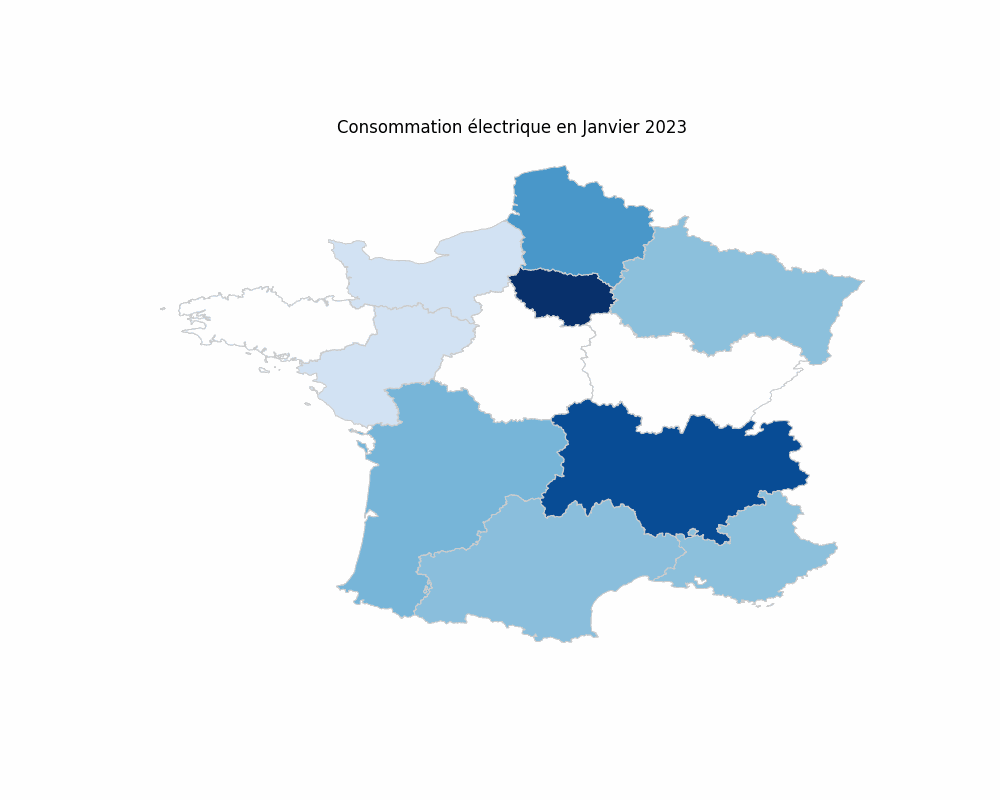

In [43]:
# Display the animation
Image(filename='carte_consommation_par_mois_2023.gif')

## Conclusion sur la consommation d'électricité en France

<h2 style="padding:16px; color:#FFF; background:#07D">V. Analyse de la production</h2>

La France est connue pour son industrie nucléaire civil. En effet, le pays a grandement misé sur cette filière pour produire de l'électricité et le nucléaire est la 1ère source de production d'électricité en France. Cependant, le développement des énergies renouvelables est un des grands enjeux de la transition énergétique et la France a également investi dans ces filières. Nous allons donc étudier la production d'électricité en France depuis 2013 et voir l'évolution des différentes filières.

## Production d'électricité en France (hors Corse)

Linechart sur la production d'électricité en France selon plusieurs échelles de temps (jour, semaine, mois, année)

In [44]:
start_date_picker_production_nationale  = DatePicker(description='Date de début', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date() - timedelta(days=1))
end_date_picker_production_nationale  = DatePicker(description='Date de fin', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date())

output_production_nationale = Output()

def draw_figure_and_donut(start_date, end_date):
    df = get_data_between_dates('national', start_date, end_date)
    df['date_heure'] = pd.to_datetime(df['date_heure'])
    df = df.sort_values(by=['date_heure']).dropna()

    sum_by_filiere = df[['nucleaire', 'hydraulique', 'eolien', 'solaire', 'bioenergies', 'gaz', 'fioul', 'charbon']].sum()

    with output_production_nationale:
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 2]}, figsize=(15, 6))
        
        ax[0].plot(df['date_heure'], df['nucleaire'], label='Nucléaire')
        ax[0].plot(df['date_heure'], df['hydraulique'], label='Hydraulique')
        ax[0].plot(df['date_heure'], df['eolien'], label='Eolien')
        ax[0].plot(df['date_heure'], df['solaire'], label='Solaire')
        ax[0].plot(df['date_heure'], df['bioenergies'], label='Bioenergies')
        ax[0].plot(df['date_heure'], df['gaz'], label='Gaz')
        ax[0].plot(df['date_heure'], df['fioul'], label='Fioul')
        ax[0].plot(df['date_heure'], df['charbon'], label='Charbon')
        ax[0].set_xlabel('Date et Heure')
        ax[0].set_ylabel('Production (MW)')
        ax[0].set_title(f'Production électrique en France du {start_date} au {end_date}')
        ax[0].legend()

        # Create a mask for values greater than 4%
        mask = (sum_by_filiere / sum_by_filiere.sum() * 100) > 2

        # Create labels with percentages only for those that are above the threshold
        labels = [f'{index}: {value:.1f}%' if flag else '' for index, value, flag in zip(sum_by_filiere.index, sum_by_filiere / sum_by_filiere.sum() * 100, mask)]

        # Plotting the pie chart with the custom labels
        ax[1].pie(sum_by_filiere, labels=labels, startangle=140, wedgeprops=dict(width=0.3))
        ax[1].set_title('Proportion de production par filière')

        plt.show()

def update_figure_production_nationale(change):
    with output_production_nationale:
        clear_output(wait=True)  # Clear the previous graph
        draw_figure_and_donut(start_date_picker_production_nationale.value, end_date_picker_production_nationale.value)

start_date_picker_production_nationale.observe(update_figure_production_nationale, names='value')
end_date_picker_production_nationale.observe(update_figure_production_nationale, names='value')

display(VBox([HBox([start_date_picker_production_nationale, end_date_picker_production_nationale]), output_production_nationale]))

update_figure_production_nationale(None)


## Production d'électricité par région et par filière

Grille avec :
- Datepicker pour choisir la date/mois/année
- interact avec choix entre 'régions' et 'filières'
- Piechart sur la somme de la production d'électricité par filière/région sur la période choisie
- Linechart avec toutes les filières/régions qui se superposent sur la période choisie

In [58]:
# Create a dictionary to map regions to colors
region_colors = {}
region_colors['Centre-Val de Loire'] = 'red'
region_colors['Grand Est'] = 'blue'
region_colors['Nouvelle-Aquitaine'] = 'green'
region_colors['Occitanie'] = 'orange'
region_colors['Provence-Alpes-Côte d\'Azur'] = 'brown'
region_colors['Pays de la Loire'] = 'pink'
region_colors['Bourgogne-Franche-Comté'] = 'gray'
region_colors['Hauts-de-France'] = 'olive'
region_colors['Normandie'] = 'cyan'
region_colors['Bretagne'] = 'magenta'
region_colors['Île-de-France'] = 'yellow'
region_colors['Auvergne-Rhône-Alpes'] = 'purple'

# Creqte date pickers and dropdown
start_date_picker_production_region = DatePicker(description='Date de début', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date() - timedelta(days=1))
end_date_picker_production_region = DatePicker(description='Date de fin', disabled=False, value=datetime.strptime("2023-11-01", "%Y-%m-%d").date())

filiere_picker = Dropdown(options=['nucleaire', 'hydraulique', 'eolien', 'solaire', 'bioenergies', 'thermique'], description='Filière', disabled=False)

output_production_region = Output()

def draw_figure_production_region(start_date, end_date, filiere):
    """
    Function to draw the figure for the production by region for a given filiere.

    Parameters:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD'
        filiere (str): Name of the filiere.
    """

    df_plot = get_data_between_dates('regional', start_date, end_date)
    df_plot['date_heure'] = pd.to_datetime(df_plot['date_heure'])
    df_plot = df_plot.sort_values(by=['date_heure'])

    regions = df_plot['libelle_region'].unique()

    sum_by_region = df_plot.groupby('libelle_region')[filiere].sum().reset_index()

    with output_production_region: 
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 2]}, figsize=(15, 6))

        for region in regions:
            regional_data = df_plot[df_plot['libelle_region'] == region]
            ax[0].plot(regional_data['date_heure'], regional_data[filiere], label=region, color=region_colors[region])

        ax[0].set_xlabel('Date et Heure')
        ax[0].set_ylabel(f'Production ({filiere}) (MW)')
        ax[0].set_title(f'Production électrique {filiere} en France par région du {start_date.strftime("%Y-%m-%d")} au {end_date.strftime("%Y-%m-%d")}')
        ax[0].legend()

        total_production = sum_by_region[filiere].sum()
        percentages = sum_by_region[filiere] / total_production * 100
        sum_by_region = sum_by_region[percentages > 2]

        pie_colors = [region_colors[region] for region in sum_by_region['libelle_region']]

        ax[1].pie(sum_by_region[filiere], labels=sum_by_region['libelle_region'], autopct=lambda p: '{:.1f}%'.format(p) if p > 2 else '', startangle=140, colors=pie_colors)
        ax[1].set_title(f'Proportion de production {filiere} par région du {start_date} au {end_date}')

        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig.gca().add_artist(centre_circle)

        plt.tight_layout() 
        plt.show()
        
def update_charts(change):
    """
    Function to update the charts when the date pickers or dropdown are changed.
    """

    with output_production_region:
        clear_output(wait=True)
        draw_figure_production_region(start_date_picker_production_region.value, end_date_picker_production_region.value, filiere_picker.value)
    
start_date_picker_production_region.observe(update_charts, names='value')
end_date_picker_production_region.observe(update_charts, names='value')
filiere_picker.observe(update_charts, names='value')

display(VBox([HBox([start_date_picker_production_region, end_date_picker_production_region, filiere_picker]), output_production_region]))

update_charts(None)

## Évolution du la part du renouvelable dans le mix énergétique

Carte de la France avec évolution de la part du renouvelable dans le mix énergétique

In [65]:
# Get the data
df_regional = get_all_data('regional')
# Add a year column
df_regional['annee'] = pd.DatetimeIndex(df_regional['date']).year
# Group the data by year
df_regional = df_regional.groupby(['annee', 'libelle_region']).mean(numeric_only=True).reset_index()
# Filter out 2024
df_regional = df_regional.drop(df_regional[df_regional['annee'] == 2024].index).reset_index(drop=True)
# Fill NaN values with 0
df_regional.fillna(0, inplace=True)

In [66]:
df_regional['production_renouvelable'] = df_regional['thermique'] + df_regional['eolien'] + df_regional['solaire'] + df_regional['hydraulique'] + df_regional['bioenergies']
df_regional['production_totale'] =  df_regional['production_renouvelable'] + df_regional['nucleaire']
df_regional['part_renouvable'] = df_regional['production_renouvelable'] / df_regional['production_totale']

df_regional

,annee,libelle_region,consommation,thermique,nucleaire,eolien,solaire,hydraulique,bioenergies,ech_physiques,production_renouvelable,production_totale,part_renouvable
0,2013,Auvergne-Rhône-Alpes,7878.772146,157.858114,10288.867652,86.210087,50.762421,3872.159965,64.301477,-6217.961723,4231.292064,14520.159716,0.291408
1,2013,Bourgogne-Franche-Comté,2559.255088,128.892839,0.000000,32.720464,16.830355,120.642901,12.552184,2243.804418,311.638744,311.638744,1.000000
2,2013,Bretagne,2619.418043,28.640575,0.000000,155.357109,17.590688,58.575722,21.715109,2340.858059,281.879202,281.879202,1.000000
3,2013,Centre-Val de Loire,2228.370977,37.636536,7735.862695,170.975973,19.180667,18.613109,28.137305,-5783.234796,274.543590,8010.406285,0.034273
4,2013,Grand Est,5355.315925,1341.974012,8801.048782,396.757906,48.878014,1087.539107,49.932619,-6244.910076,2925.081658,11726.130440,0.249450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2023,Nouvelle-Aquitaine,5098.519518,140.416189,4180.635656,469.268671,416.558396,488.033453,85.842982,-681.043801,1600.119690,5780.755346,0.276801
128,2023,Occitanie,4181.752756,37.715983,537.770608,397.471810,517.009083,1030.090717,130.390660,1732.170037,2112.678252,2650.448861,0.797102
129,2023,Pays de la Loire,2845.299786,214.531424,0.000000,488.116303,137.809300,6.158979,62.102268,1941.630787,908.718273,908.718273,1.000000
130,2023,Provence-Alpes-Côte d'Azur,4297.368209,570.049532,0.000000,22.449558,363.449685,928.751939,113.843447,2314.920211,1998.544161,1998.544161,1.000000


In [67]:
# Load the map
map_df = gpd.read_file("./regions.geojson", crs="EPSG:2154")

# Create the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the map
def init():
    """Initiliaze the figure."""
    ax.set_title('Part du renouvelable dans la production électrique')
    ax.set_axis_off()
    return

def update(frame):
    """Update the figure."""
    date = df_regional['annee'].unique()[frame]
    print(f'Processing {date}')
    daily_data = df_regional[df_regional['annee'] == date]
    merged = map_df.set_index('nom').join(daily_data.set_index('libelle_region'))
    
    merged.plot(column='part_renouvable', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(f'Part du renouvelable dans la production électrique en {date}')

# Create the animation
frames = len(df_regional['annee'].unique())
animation = FuncAnimation(fig, update, frames=frames, init_func=init, blit=False, repeat=True)

# Save the animation
writer = PillowWriter(metadata=dict(title='Part du renouvelable dans la production électrique'))
animation.save(filename='carte_part_du_renouvelable_par_annee.gif', writer=writer)

# Close the figure
plt.close()

Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
Processing 2022
Processing 2023


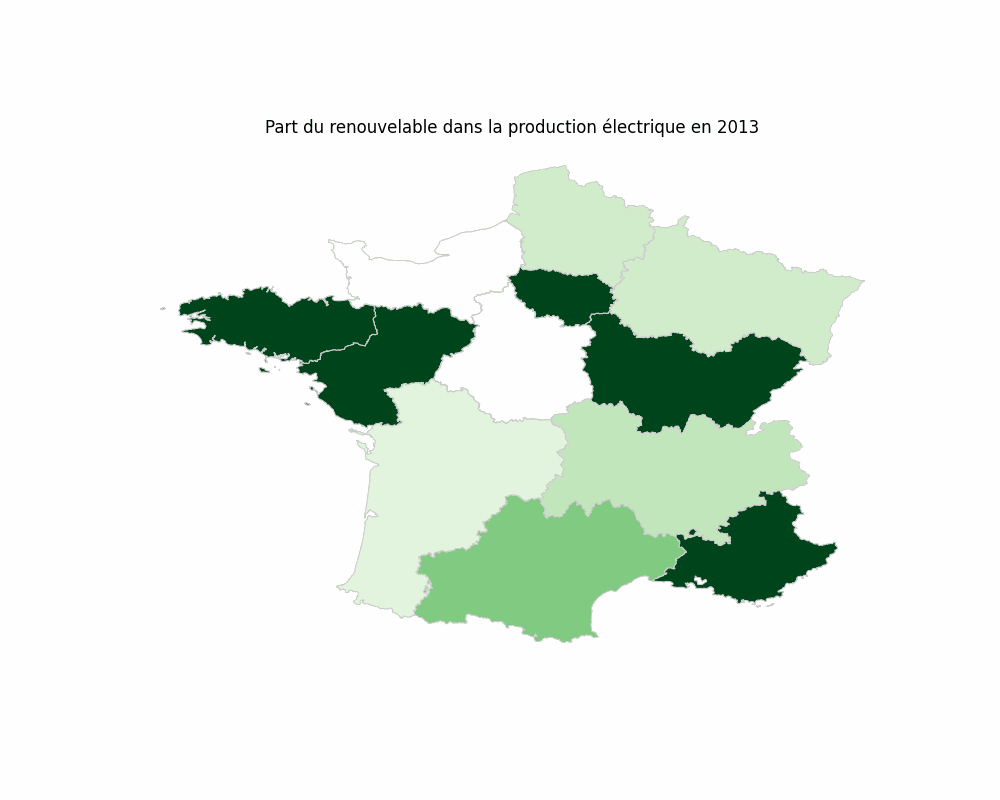

In [68]:
# Display the animation
Image(filename='carte_part_du_renouvelable_par_annee.gif')

## Conclusion sur la production d'électricité en France

<h2 style="padding:16px; color:#FFF; background:#07D">VI. Analyse des échanges commerciaux</h2>

Suite à nos analyses sur la production et la consommation d'électricité en France, nous avons pu voir que la France est un pays qui produit plus d'électricité qu'il n'en consomme. Nous pouvons donc nous dire que la France exporte de l'électricité avec d'autres pays. Nous allons donc étudier les échanges commerciaux d'électricité entre la France et ses pays voisins.

linechart de densité avec les échanges commerciaux entre la France et ses pays voisins avec positif et négatif sur plusieurs échelles de temps (jour, mois, année)

Conclusion à la suite (petite partie)

In [13]:
start_date_picker_echanges = DatePicker(description='Date de début', disabled=False, value=datetime.now().date() - timedelta(days=1))
end_date_picker_echanges = DatePicker(description='Date de fin', disabled=False, value=datetime.now().date())

output_echanges = Output()

def draw_stacked_bar_chart(start_date, end_date):
    df = get_trade_data(start_date, end_date)
    df = df.sort_values(by=['date_heure']).dropna()

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df_cum = df.clip(lower=0)  # Clip the negative values and sum the values
    df_cum_neg = df.clip(upper=0) # Clip the positive values and sum the values

    colors = ['blue', 'orange', 'green', 'red', 'purple']
    labels = ['Angleterre', 'Espagne', 'Italie', 'Suisse', 'Allemagne/Belgique']
    legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
    
    with output_echanges:
        clear_output(wait=True)  
        
        fig, ax = plt.subplots(figsize=(14, 5))
        df_cum.plot(kind='bar', stacked=True, ax=ax, width=0.95, color=colors) # Plot the positive values
        df_cum_neg.plot(kind='bar', stacked=True, ax=ax, width=0.95, color=colors) # Plot the negative values

        ax.axhline(0, color='grey', linewidth=0.8)
        ax.set_ylabel('Valeur des échanges (MW)')
        ax.set_xlabel('Date et Heure')
        ax.set_title('Échanges commerciaux par heure')
        
        ticks = ax.get_xticks()
        ticklabels = [l.get_text() for l in ax.get_xticklabels()]
        ax.set_xticks(ticks[::15]) 
        ax.set_xticklabels(ticklabels[::15], rotation=45, ha="right")

        ax.legend(legend_patches, labels, loc='lower left', bbox_to_anchor=(1, 0))
        plt.tight_layout() 
        plt.show()

def calculate_trade_totals(df):
    exports = df[df < 0].sum().abs()  
    imports = df[df > 0].sum()       

    return exports, imports

def display_trade_totals(start_date, end_date):
    df = get_trade_data(start_date, end_date)
    df = df.sort_values(by=['date_heure']).dropna()

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    exports, imports = calculate_trade_totals(df)

    totals_df = pd.DataFrame({
        'Exportations': exports,
        'Importations': imports
    })

    with output_echanges:
        print("Totaux d'échanges commerciaux (MW):")
        print(totals_df)
        print()

def update_figure_echanges(change):
    draw_stacked_bar_chart(start_date_picker_echanges.value, end_date_picker_echanges.value)
    display_trade_totals(start_date_picker_echanges.value, end_date_picker_echanges.value)

start_date_picker_echanges.observe(update_figure_echanges, names='value')
end_date_picker_echanges.observe(update_figure_echanges, names='value')

display(VBox([HBox([start_date_picker_echanges, end_date_picker_echanges]), output_echanges]))

update_figure_echanges(None)


<h2 style="padding:16px; color:#FFF; background:#07D">Conclusion de l'étude</h2>